# Predicciones a patrones estacionarios / horizontales

Para estas series, estos patrones **no tiene tendencia ni estacionalidad**; oscila alrededor de un valor promedio constante.
Es el tipo ideal para aplicar modelos simples como el **promedio móvil simple** o la **atenuación exponencial simple**.

**Promedio Móvil Simple (PMA)**

Es el promedio aritmético de los últimos \(k\) valores observados.

$$
\hat{y}_{t+1} = \frac{y_t + y_{t-1} + \dots + y_{t-k+1}}{k}
$$
Donde: 
- $ \hat{y}_{t+1}$ : predicción para el siguiente período
- $ y_t $: valor en el tiempo actual
- $ k $: número de períodos considerados (ventana)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm
import math

In [2]:
# Ejemplo de una serie
data = [9.29,9.99,10.16,10.25,10.61,11.07,11.52,11.09,10.8,10.5,10.86,9.97]


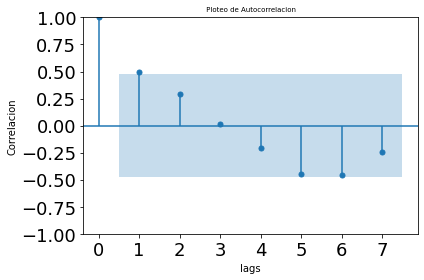

In [3]:
#primero debemos averiguar el patron predominante en esta serie aplicando a del 90%.

#test de hipotesis
plt.rc("figure", figsize=(10,6))

#funcion de autocorrelacion y ploteo
plot_acf(data, lags=7,alpha=0.1,bartlett_confint=False)

plt.ylim(-1,1)
plt.xlabel('lags', fontsize=10)
plt.ylabel('Correlacion', fontsize=10)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title(' Ploteo de Autocorrelacion', fontsize=7)
plt.tight_layout()
plt.show()

In [4]:
# Promedio móvil simple con ventana "a"
def pms(data, a):
    
    series = pd.Series(data)
    sma = series.rolling(window=a).mean().shift(1)
    # se desliza una posicion dado que estos metodos tambien se aplica para suavizar los valores.
    if len(series) >= a:
        futuro = pd.Series([series.iloc[-a:].mean()])
    else:
        futuro = pd.Series([np.nan])
    
    resultado = pd.concat([sma, futuro], ignore_index=True)
    
    return resultado

In [5]:
#Con 3 periodos
print("Con 3 periodos")
pms3 = pms(data,3)
print(pms3)

print("Con 5 periodos")
pms5=pms(data,5)
print(pms5)

Con 3 periodos
0           NaN
1           NaN
2           NaN
3      9.813333
4     10.133333
5     10.340000
6     10.643333
7     11.066667
8     11.226667
9     11.136667
10    10.796667
11    10.720000
12    10.443333
dtype: float64
Con 5 periodos
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5     10.060
6     10.416
7     10.722
8     10.908
9     11.018
10    10.996
11    10.954
12    10.644
dtype: float64


**Atenuación Exponencial Simple**

Es un promedio ponderado donde se da más peso a los valores más recientes.
$$
\hat{y}_{t+1} = \alpha y_t + (1 - \alpha) \hat{y}_t
$$

- $ \alpha \in [0,1]$: parámetro de suavizamiento
  - Si $ \alpha $ es grande → más peso a los datos recientes
  - Si $ \alpha $ es pequeño → más peso al historial
  - Usualmente para tener una prediccion cercano a lo real, el parametro varia entre 0.2 y 0.5
- $ \hat{y}_{t} $: pronóstico en el período actual
- $ y_t $: valor observado actual



In [6]:
def aes(data,a):
    series =pd.Series(data) 
    aes = series.ewm(alpha=a, adjust=False).mean().shift(1)
    futuro = pd.Series([series.ewm(alpha=a, adjust=False).mean().iloc[-1]])
    resultado = pd.concat([aes, futuro], ignore_index=True)

    return resultado

In [7]:
# Con una atenuacion del 0.3
aes3=aes(data,0.3)
print(aes3)


0           NaN
1      9.290000
2      9.500000
3      9.698000
4      9.863600
5     10.087520
6     10.382264
7     10.723585
8     10.833509
9     10.823457
10    10.726420
11    10.766494
12    10.527546
dtype: float64


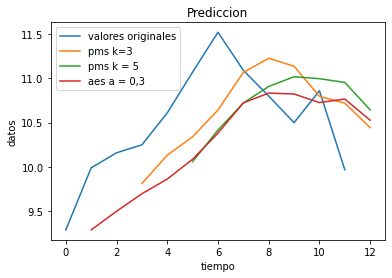

In [8]:
# Plot original data, PMS y AES
plt.plot(data, label='valores originales')
plt.plot(pms3, label='pms k=3')
plt.plot(pms5, label='pms k = 5')
plt.plot(aes3, label='aes a = 0,3')
plt.xlabel('tiempo')
plt.ylabel('datos')
plt.title('Prediccion')
plt.legend()
plt.show()

# Como podemos determinar la prediccion más acertada?


Para determinar una prediccion mas cercano al comportamiendo de los datos aplicamos distintos estimadores para detectar el más acertado.

Todo parte con la medición más simple: Que tan alejado esta el pronostico con el dato real.

$$ error = y_{t}-\hat{y}_{t} $$

**Desviacion absoluta media (DAM)**: 
Medida para calcular cuanto varian de su media los valores del conjunto de datos en terminos absolutos. 

$$ DAM = \frac{\sum ^{n}_{t=1} |error|}{n}$$


**Error medio cuadratico (EMC)** :
Esta estimacion determina el error entre dos conjuntos de datos, en este caso entre el valor predicho con el valor medido. Se aplica el cuadrado para resaltar las diferencias más distantes entre los valores.

$$ EMC = \frac{\sum ^{n}_{t=1} (error)^2}{n}$$

**Porcentaje de error medio absoluto (PEMA)**:
Esta medida nos entrega en terminos porcentuales del error absoluto entre el valor predicho con el valor real. Esta estimacion es util para comparar modelos entre distintas escalas. 

$$ PEMA = \frac{100}{n} \sum_{t=1}^{n} \left| \frac{error}{y_t} \right| $$


**Porcentaje medio de error (PME)**:
Mide el **promedio simple del error**. Indica si el modelo tiende a **sobreestimar o subestimar**. Con esta medida podemos determinar si existe un sesgo.

$$ PME = \frac{100}{n} \sum_{t=1}^{n} \left( \frac{error}{y_t} \right)  $$

- Un valor positivo → el modelo subestima.
- Un valor negativo → el modelo sobreestima.

Es importante aclarar que tanto **PEMA y PME** son estimadores porcentuales

Para determinar el pronostico más preciso se tienen que comparar y ver quien obtuvo los resultados más cercano al 0 positivo. (sobretodo el PME). (Si, dije 0 positivo)

Estos estimadores igualmente se ocupan en IA. Existen librerias que estan estos estimadores como el sklearn

In [9]:
def calcular_errores(data,pron):
    #eliminamos el pronostico para comparar valores
    pron = pron.iloc[:-1]
    #preparacion de datos
    y_true, y_pred = np.array(data), np.array(pron)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    #DAM
    dam= np.mean(np.abs((y_true_clean - y_pred_clean)))
    
    #EMC
    emc= np.mean(pow((y_true_clean - y_pred_clean),2))
    
    #PEMA
    pema = np.mean(np.abs((y_true_clean - y_pred_clean)/y_true_clean))*100
    
    #PME
    pme = np.mean((y_true_clean - y_pred_clean)/y_true_clean)*100
    
    return dam,emc,pema,pme


def mostrar_resultados(y_true,y_pred):
    dam,emc,pema,pme = calcular_errores(y_true,y_pred)
    print(f"DAM : {dam}")
    print(f"EMC : {emc}")
    print(f"PEMA: {pema}")
    print(f"PME: {pme}")
    


In [10]:
print("PREDICCION 1 : PMS K= 3")
mostrar_resultados(data,pms3)

print("PREDICCION 2 : PMS K= 5")
mostrar_resultados(data,pms5)

print("PREDICCION 3 : AES a= 0,3")
mostrar_resultados(data,aes3)

PREDICCION 1 : PMS K= 3
DAM : 0.4911111111111113
EMC : 0.3193086419753093
PEMA: 4.587487698406649
PME: 0.6904483538395347
PREDICCION 2 : PMS K= 5
DAM : 0.6040000000000002
EMC : 0.520154285714286
PEMA: 5.582948600322109
PME: 0.710021690151977
PREDICCION 3 : AES a= 0,3
DAM : 0.5847337487345453
EMC : 0.449034562805284
PEMA: 5.508036196861232
PME: 3.4389972407563683


Con todo esto planteado: Cual seria la prediccion más acertada? Intenta jugar con los valores para encontrar la mejor prediccion. Si aplicamos valores muy extremos (como un conjunto igual al tamaño y un parametro igual a 0 o a 1) Te da mejores resultados? Es real ese pronostico?.